# Classifying using a perceptron

In this example, we will build a perceptron to learn a classification between positive and negative numbers.

The problem is summarised as:

**number -> perceptron -> is it positive? yes (1) / no (0)**

This is trivial but we will be able to see the code so we are familiar for more complex problems later-on.

### Set-up (installing and importing)

In [38]:
!pip install torch numpy matplotlib

import numpy as np
import torch as pt
import matplotlib.pyplot as plt

### Download data

In [39]:
!wget -O x.txt https://github.com/s-sd/EMS741/raw/refs/heads/main/tutorials/intro_to_dl_example/x.txt
!wget -O y.txt https://github.com/s-sd/EMS741/raw/refs/heads/main/tutorials/intro_to_dl_example/y.txt

--2026-02-04 14:33:12--  https://github.com/s-sd/EMS741/raw/refs/heads/main/tutorials/intro_to_dl_example/x.txt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/s-sd/EMS741/refs/heads/main/tutorials/intro_to_dl_example/x.txt [following]
--2026-02-04 14:33:12--  https://raw.githubusercontent.com/s-sd/EMS741/refs/heads/main/tutorials/intro_to_dl_example/x.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25481 (25K) [text/plain]
Saving to: ‘x.txt’

x.txt               100%[===================>]  24.88K  --.-KB/s    in 0s      

2026-02-04 14:33:13 (72.6 MB/s) - ‘x.txt’ saved [25481/25481]

--2026

### Check the data

In [40]:
!ls

sample_data  x.txt  y.txt


In [41]:
x = np.loadtxt('x.txt')
y = np.loadtxt('y.txt')

In [42]:
print('X shape: ', np.shape(x))
print('Y shape: ', np.shape(y))

print('\n')
print('X min: ', np.amin(x))
print('X max: ', np.amax(x))

print('\n')
print('Y min: ', np.amin(y))
print('Y max: ', np.amax(y))
print('\n')


# plot some samples
sample_indexes = np.random.randint(0, len(y), 16)

x_samples = x[sample_indexes]
y_samples = y[sample_indexes]

for i in range(len(x_samples)):
  print('Input: ', x_samples[i], ', Label: ', y_samples[i])

X shape:  (1000,)
Y shape:  (1000,)


X min:  -1996.0
X max:  1996.0


Y min:  0.0
Y max:  1.0


Input:  219.0 , Label:  1.0
Input:  -708.0 , Label:  0.0
Input:  -964.0 , Label:  0.0
Input:  -256.0 , Label:  0.0
Input:  -635.0 , Label:  0.0
Input:  -837.0 , Label:  0.0
Input:  -362.0 , Label:  0.0
Input:  1919.0 , Label:  1.0
Input:  108.0 , Label:  1.0
Input:  799.0 , Label:  1.0
Input:  -104.0 , Label:  0.0
Input:  -1817.0 , Label:  0.0
Input:  -1632.0 , Label:  0.0
Input:  -1095.0 , Label:  0.0
Input:  1172.0 , Label:  1.0
Input:  -1160.0 , Label:  0.0


In [43]:
# now let's squish/ normalise the x values to between 0 to 1 assuming min, max of -2000, +2000
# this helps tokeep the weights stable during leanring

min_x = -2000
max_x = 2000

x_normalised = (x - min_x) / (max_x - min_x)

print('\n')
print('X_normalised min: ', np.amin(x_normalised))
print('X_normalised max: ', np.amax(x_normalised))




X_normalised min:  0.001
X_normalised max:  0.999


### Split the data into relevant sets

In [44]:
# Shuffle the data randomly
indexes = np.random.permutation(len(x))
x_final = x_normalised[indexes]
y_final = y[indexes]

# split into train, val and test sets
train_val_test_ratio = [0.6, 0.2, 0.2]

train_index_start = 0
train_index_end = int(train_val_test_ratio[0] * len(x))

val_index_start = train_index_end
val_index_end = val_index_start + int(train_val_test_ratio[1] * len(x))

test_index_start = val_index_end
test_index_end = test_index_start + int(train_val_test_ratio[2] * len(x))


x_train, y_train = x_final[train_index_start:train_index_end], y_final[train_index_start:train_index_end]

x_val, y_val = x_final[val_index_start:val_index_end], y_final[val_index_start:val_index_end]

x_test, y_test = x_final[test_index_start:test_index_end], y_final[test_index_start:test_index_end]


print("Train:", x_train.shape, y_train.shape)
print("Val:", x_val.shape, y_val.shape)
print("Test: ", x_test.shape,  y_test.shape)


Train: (600,) (600,)
Val: (200,) (200,)
Test:  (200,) (200,)


### Build a perceptron

y = f(x; w)

Where we apply non-linear activation to the element-wise multiplication of w and x, which is a single perceptron. Note that the bias term is added automatically.

In [45]:
# pt requires conversion to the special pt datatype called a torch.tensor
# convert all data to torch.tensor

x_train_t = pt.tensor(x_train, dtype=pt.float32).view(-1, 1)
y_train_t = pt.tensor(y_train, dtype=pt.float32).view(-1, 1)

x_val_t   = pt.tensor(x_val,   dtype=pt.float32).view(-1, 1)
y_val_t   = pt.tensor(y_val,   dtype=pt.float32).view(-1, 1)

x_test_t  = pt.tensor(x_test,  dtype=pt.float32).view(-1, 1)
y_test_t  = pt.tensor(y_test,  dtype=pt.float32).view(-1, 1)

# Optional: choose device (gpu if available) and add all tensors to gpu
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
x_train_t, y_train_t = x_train_t.to(device), y_train_t.to(device)
x_val_t,   y_val_t   = x_val_t.to(device),   y_val_t.to(device)
x_test_t,  y_test_t  = x_test_t.to(device),  y_test_t.to(device)

In [46]:
# now we can define the perceptron

class Perceptron(pt.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = pt.nn.Linear(1, 1)  # 1 in, 1 out (adding bias is implied)

    def forward(self, x):
        logits = self.linear(x)        # shape (N, 1)
        probs = pt.sigmoid(logits)  # sigmoid activation
        return probs

model = Perceptron().to(device)
print(model)

# Equivalent to tf keras: binary_crossentropy
criterion = pt.nn.BCELoss()
optimizer = pt.optim.Adam(model.parameters(), lr=0.1)

epochs = 10
batch_size = 16


Perceptron(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [47]:
# now we need a training loop

epochs = 10
batch_size = 16

train_losses = []
val_losses = []

N = x_train_t.shape[0]

for epoch in range(epochs):
    # ---- Train ----
    model.train()
    perm = pt.torch.randperm(N, device=device)

    epoch_train_loss = 0.0
    for i in range(0, N, batch_size):
        idx = perm[i:i+batch_size]
        xb = x_train_t[idx]
        yb = y_train_t[idx]

        optimizer.zero_grad()
        y_pred = model(xb)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * xb.size(0)

    epoch_train_loss /= N
    train_losses.append(epoch_train_loss)

    # ---- Validation ----
    model.eval()
    with pt.torch.no_grad():
        y_val_pred = model(x_val_t)
        val_loss = criterion(y_val_pred, y_val_t).item()
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1:02d}/{epochs} | train loss: {epoch_train_loss:.4f} | val loss: {val_loss:.4f}")


Epoch 01/10 | train loss: 0.5934 | val loss: 0.4484
Epoch 02/10 | train loss: 0.3675 | val loss: 0.3113
Epoch 03/10 | train loss: 0.2712 | val loss: 0.2478
Epoch 04/10 | train loss: 0.2231 | val loss: 0.2109
Epoch 05/10 | train loss: 0.1912 | val loss: 0.1879
Epoch 06/10 | train loss: 0.1702 | val loss: 0.1701
Epoch 07/10 | train loss: 0.1550 | val loss: 0.1581
Epoch 08/10 | train loss: 0.1432 | val loss: 0.1455
Epoch 09/10 | train loss: 0.1330 | val loss: 0.1376
Epoch 10/10 | train loss: 0.1248 | val loss: 0.1277


### Plotting losses

Text(0, 0.5, 'loss')

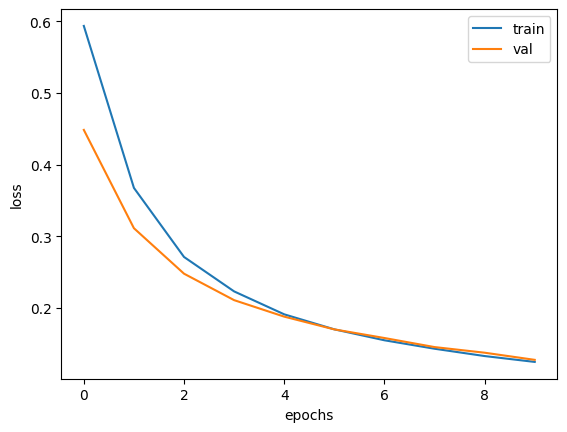

In [48]:
plt.plot(train_losses)
plt.plot(val_losses)

plt.legend(['train', 'val'])
plt.xlabel('epochs')
plt.ylabel('loss')

### Evalute the model

In [49]:
model.eval()
with pt.torch.no_grad():
    y_test_pred = model(x_test_t)
    preds = (y_test_pred > 0.5).float()
    acc = (preds.eq(y_test_t)).float().mean().item()

print(f"Test accuracy: {acc:.3f}")

w = model.linear.weight.detach().cpu().numpy()  # shape (1, 1)
b = model.linear.bias.detach().cpu().numpy()    # shape (1,)

print("Learned weight:", float(w[0, 0]))
print("Learned bias:  ", float(b[0]))

Test accuracy: 0.985
Learned weight: 12.95073127746582
Learned bias:   -6.218820095062256
